# High Dynamic Range (HDR) Imaging

**Satya Mallick, LearnOpenCV.com**

!["HDR Image Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_high-dynamic-range-hdr.jpg)

In [2]:
# Import Libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

##  <font style="color:black">Download Assets</font>

In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [4]:
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

# Basic Idea

1. The **dynamic range** of images is limited to 8-bits (0 - 255) per channel
2. Very bright pixels saturate to 255
3. Very dark pixels clip to 0

# Step 1: Capture Multiple Exposures

!["HDR Image Sequence"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_hdr-image-sequence.jpg)

In [5]:
def readImagesAndTimes():
    # List of file names
    filenames = ["img_0.033.jpg", "img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]

    # List of exposure times
    times = np.array([1 / 30.0, 0.25, 2.5, 15.0], dtype=np.float32)

    # Read images
    images = []
    for filename in filenames:
        im = cv2.imread(filename)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        images.append(im)

    return images, times

# Step 2: Align Images

![Aligned vs. Unaligned](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_10_aligned-unaligned-hdr-comparison.jpg)

**MTB (Median Threshold Bitmap)** adalah salah satu algoritma yang digunakan dalam proses image alignment (penyejajaran gambar) untuk mencocokkan gambar-gambar dengan eksposur yang berbeda sehingga dapat digunakan untuk pembuatan HDR (High Dynamic Range) image. Algoritma MTB digunakan untuk menemukan pergeseran, rotasi, dan skala antara gambar-gambar tersebut agar semuanya sesuai dengan referensi yang ditentukan.

In [6]:
# Read images and exposure times
images, times = readImagesAndTimes()

# Align Images
alignMTB = cv2.createAlignMTB()
alignMTB.process(images, images)

# Step 3: Estimate Camera Response Function

Mencari **Camera Response Function (CRF)** menggunakan metode Debevec. 

**CRF** adalah fungsi yang menggambarkan hubungan antara nilai piksel gambar yang diukur dengan intensitas sebenarnya dari cahaya yang diterima oleh kamera. **Metode Debevec** merupakan salah satu metode yang umum digunakan dalam pembuatan HDR image untuk menghasilkan CRF dari sekumpulan gambar yang memiliki eksposur yang berbeda.

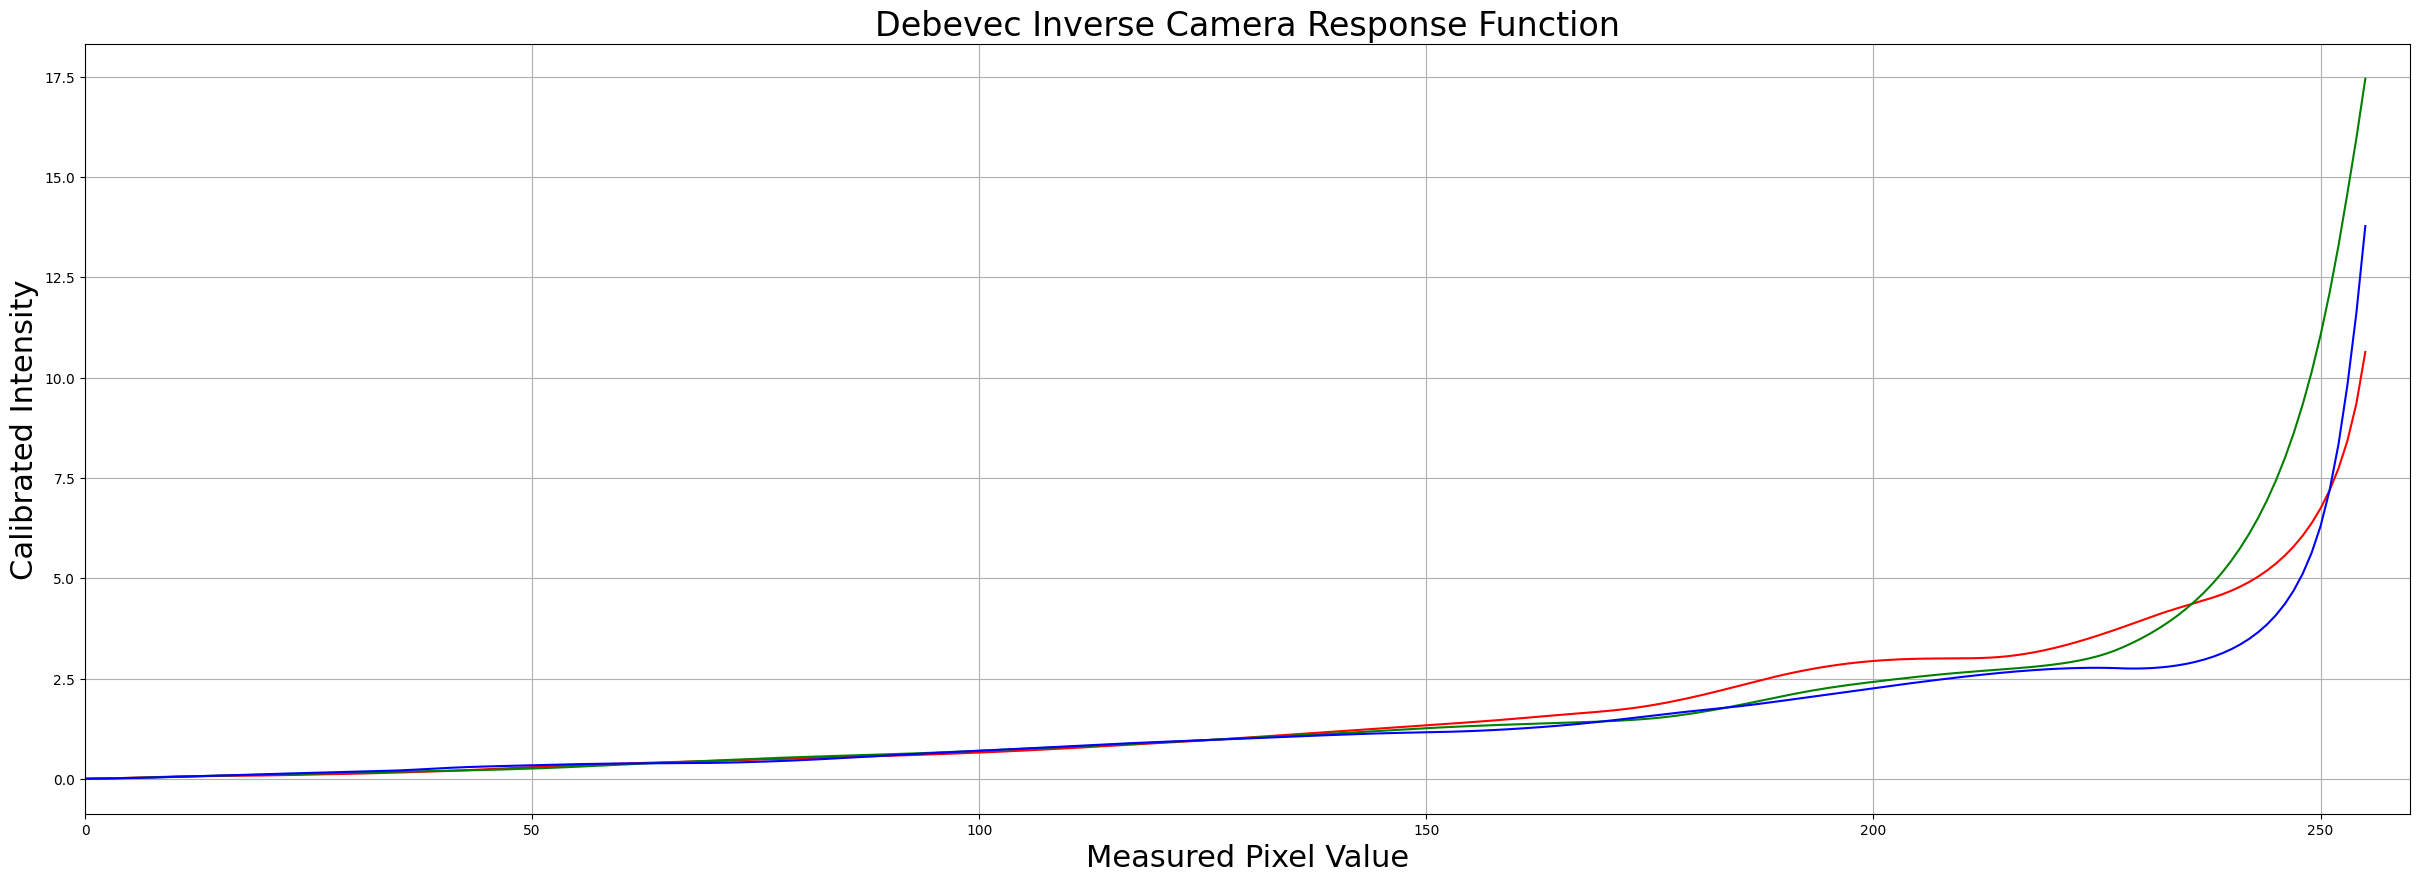

In [7]:
# Find Camera Response Function (CRF)
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Plot CRF
x = np.arange(256, dtype=np.uint8)
y = np.squeeze(responseDebevec)

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "r", x, y[:, 1], "g", x, y[:, 2], "b")

# Step 4: Merge Exposure into an HDR Image

In [28]:
# Merge images into an HDR linear image
mergeDebevec = cv2.createMergeDebevec()

# Proses penggabungan atau penyusunan gambar HDR 
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

(-0.5, 2815.5, 2111.5, -0.5)

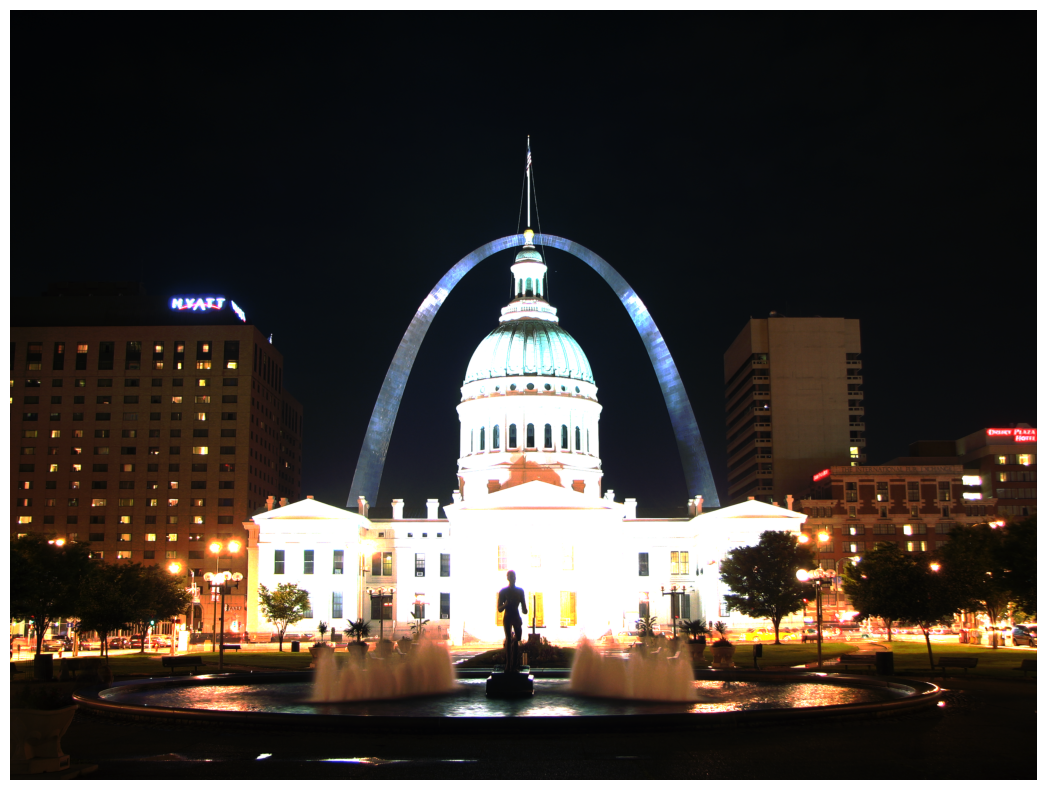

In [32]:
plt.figure(figsize=(20, 10));plt.imshow(np.clip(hdrDebevec, 0, 1));plt.axis("off")

Jika dilihat sekilas, gambar masih overexposure pada gedung.

# Step 5: Tonemapping

Many Tonemapping algorithms are available in OpenCV. We chose Durand as it has more controls.

**Tone mapping** adalah proses pengubahan citra dengan High Dynamic Range (HDR) menjadi citra dengan rentang dinamis yang lebih terbatas sehingga dapat ditampilkan pada perangkat yang memiliki rentang dinamis terbatas, seperti layar monitor atau cetakan foto.

 Tujuan dari tone mapping adalah untuk memperbaiki perbedaan kontras dan tingkat kecerahan antara area gelap dan terang pada citra HDR agar dapat dinikmati dan ditampilkan dengan lebih baik pada perangkat dengan rentang dinamis terbatas.

Citra HDR memiliki rentang dinamis yang lebih luas daripada citra standar (Low Dynamic Range - LDR). Rentang dinamis adalah perbedaan antara nilai piksel tergelap dan terterang dalam citra. Pada citra HDR, perbedaan ini bisa sangat besar, sehingga beberapa detail yang diambil dari berbagai tingkat cahaya dapat hilang atau tidak terlihat jelas pada perangkat dengan rentang dinamis terbatas.

Proses tone mapping bekerja dengan cara mengubah nilai piksel pada citra HDR sedemikian rupa sehingga nilai-nilai yang sangat terang dan sangat gelap dipersempit ke dalam rentang nilai yang dapat ditampilkan pada perangkat LDR. 

saved ldr-Drago.jpg


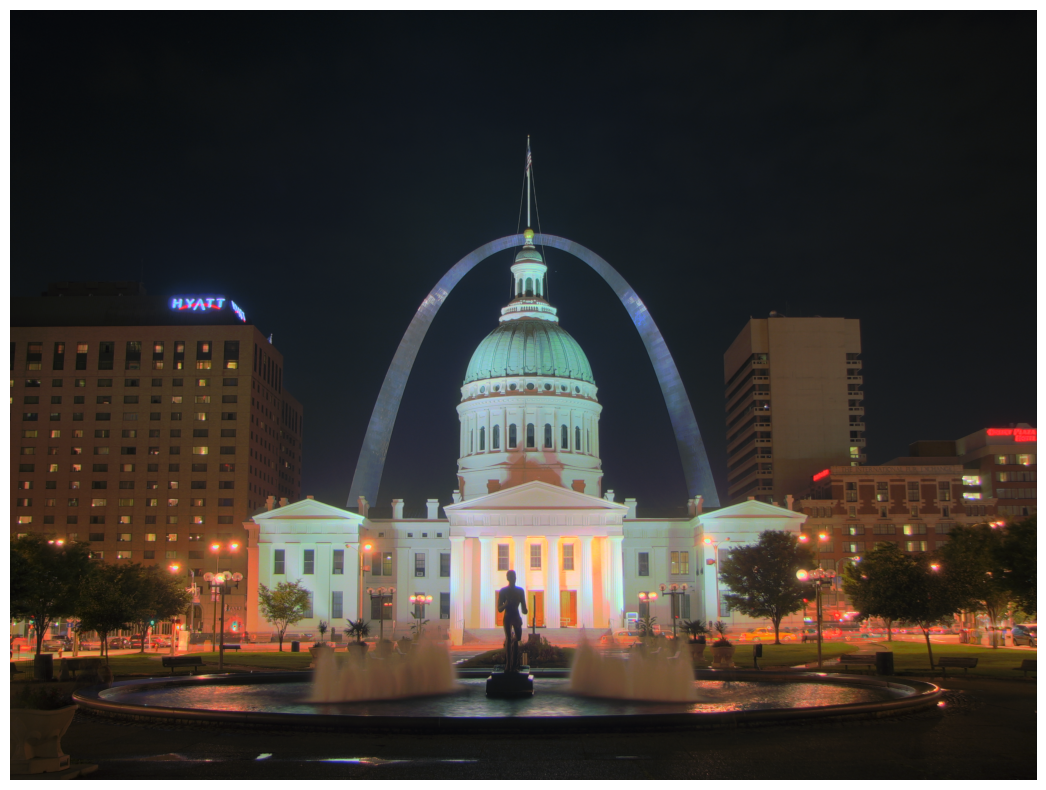

In [27]:
# Tonemap using Drago's method to obtain 24-bit color image
tonemapDrago = cv2.createTonemapDrago(1.0, 0.7)
ldrDrago = tonemapDrago.process(hdrDebevec)
ldrDrago = 3 * ldrDrago

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrDrago, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Drago.jpg", ldrDrago * 255)
print("saved ldr-Drago.jpg")

Tonemaping using Reinhard's method ... 
saved ldr-Reinhard.jpg


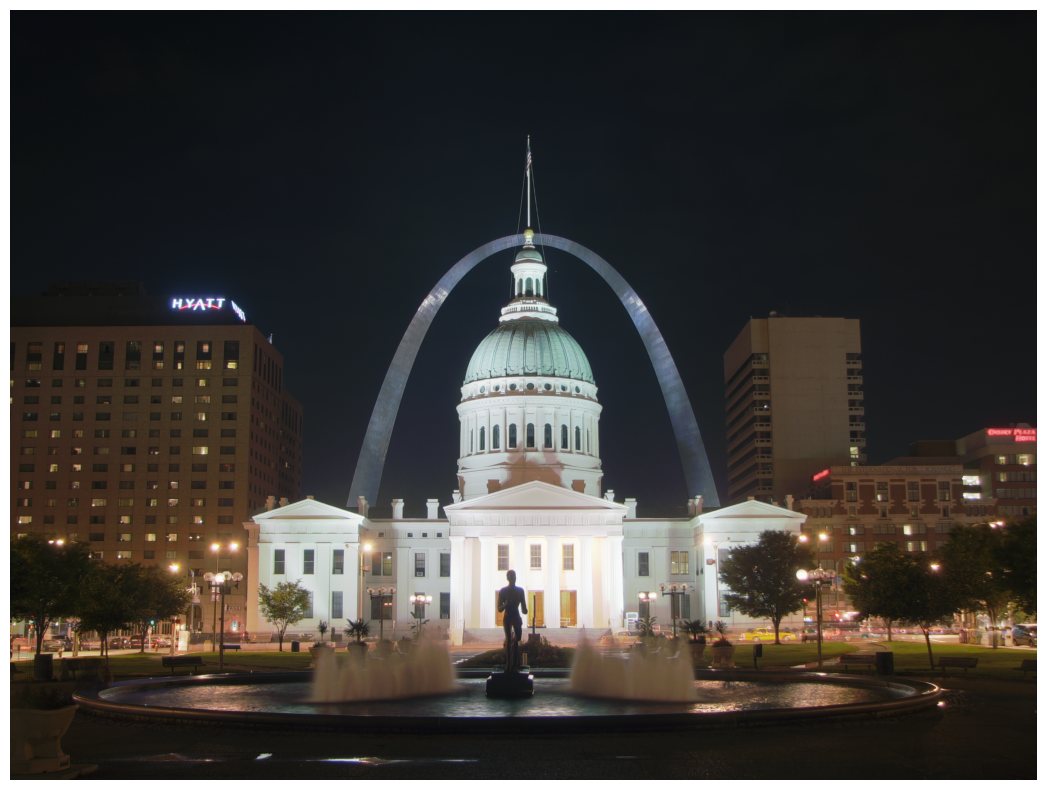

In [10]:
# Tonemap using Reinhard's method to obtain 24-bit color image
print("Tonemaping using Reinhard's method ... ")
tonemapReinhard = cv2.createTonemapReinhard(1.5, 0, 0, 0)
ldrReinhard = tonemapReinhard.process(hdrDebevec)

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrReinhard, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Reinhard.jpg", ldrReinhard * 255)
print("saved ldr-Reinhard.jpg")

Tonemaping using Mantiuk's method ... 
saved ldr-Mantiuk.jpg


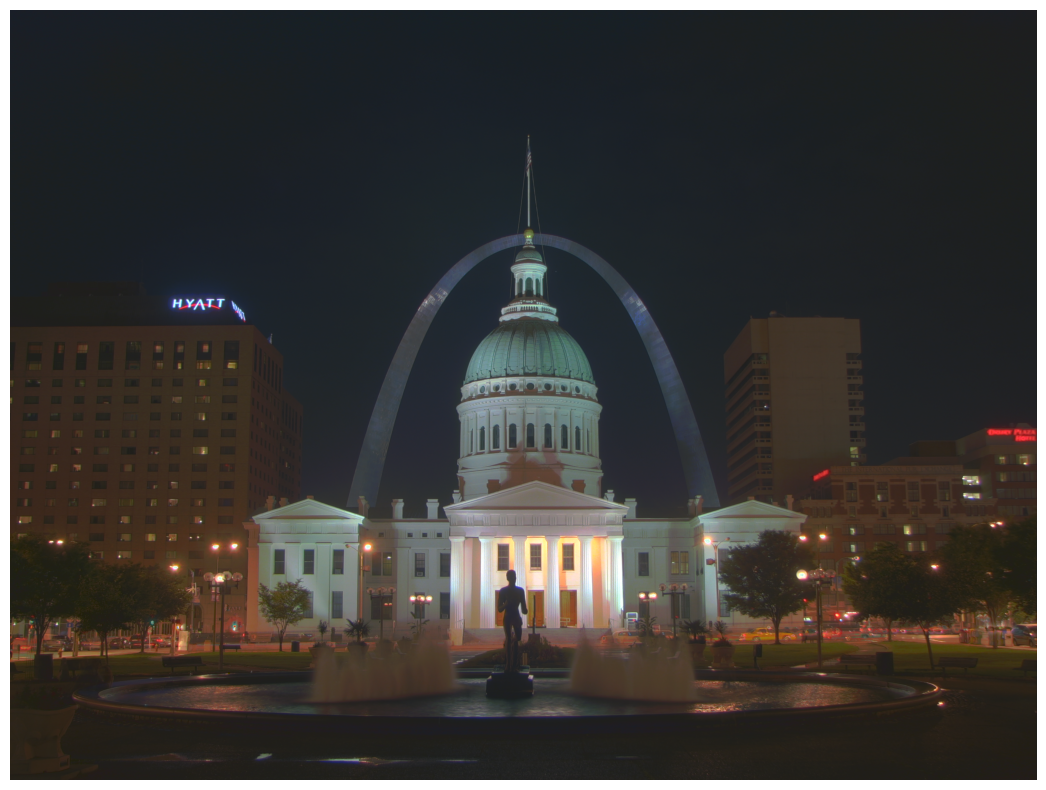

In [11]:
# Tonemap using Mantiuk's method to obtain 24-bit color image
print("Tonemaping using Mantiuk's method ... ")
tonemapMantiuk = cv2.createTonemapMantiuk(2.2, 0.85, 1.2)
ldrMantiuk = tonemapMantiuk.process(hdrDebevec)
ldrMantiuk = 3 * ldrMantiuk

plt.figure(figsize=(20, 10));plt.imshow(np.clip(ldrMantiuk, 0, 1));plt.axis("off")

cv2.imwrite("ldr-Mantiuk.jpg", ldrMantiuk * 255)
print("saved ldr-Mantiuk.jpg")

---

## Alur Pembuatan Image menjadi HDR
1. **Load Images**: Baca dua atau lebih gambar yang diambil pada eksposur yang berbeda. Gambar-gambar tersebut harus memiliki range eksposur yang berbeda untuk mencakup area dengan tingkat cahaya yang berbeda.

2. **Align Images**: Pastikan gambar-gambar tersebut sudah di-align atau sesuai dengan posisi yang tepat. Ini penting karena gambar-gambar dengan eksposur berbeda harus memiliki kesamaan posisi agar dapat di-gabungkan secara tepat.

3. **Calibrate Camera Response**: Lakukan kalibrasi respons kamera untuk setiap gambar yang digunakan. Ini adalah proses untuk memahami karakteristik respons kamera terhadap tingkat cahaya yang berbeda. Hal ini penting untuk mendapatkan data eksposur yang lebih tepat pada gambar-gambar tersebut.

4. **Merge Images to HDR**: Gabungkan gambar-gambar yang telah dikalibrasi menjadi satu gambar HDR. OpenCV menyediakan fungsi cv2.createMergeDebevec() untuk membuat HDR dari beberapa gambar dengan menggunakan metode Debevec.

5. **Tonemapping (Optional)**: Tonemapping adalah proses untuk mengonversi gambar HDR menjadi gambar dengan rentang dinamis yang lebih rendah sehingga dapat ditampilkan dengan benar pada layar dengan rentang dinamis terbatas. OpenCV menyediakan beberapa metode tonemapping seperti cv2.createTonemapDrago(), cv2.createTonemapMantiuk(), dan lain-lain.

6. **Display or Save**: Tampilkan gambar HDR yang telah selesai atau simpan gambar HDR sebagai file gambar baru.